# LiverNet-Trial-1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import*
import collections
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from tensorflow.python.keras.utils import conv_utils
# from keras_flops import get_flops

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Training/'
test_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Test'
val_path = '/content/drive/MyDrive/Published Dataset and Codes/KMC-Grading Work/KMC Grading Dataset/Validation'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)


Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [13]:
def aspp(x,num_fil,input_shape,out_stride):

    """
        ASPP Block

        Arguments:

            x: input feature map to the ASPP block
            input_shape: input shape of the feature map
            out_stride: the output stride

        Returns:

            output feature map after processing
    """

    b0=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(x)
    b0=BatchNormalization()(b0)
    b0=Activation("relu")(b0)

    b1=DepthwiseConv2D((3,3),dilation_rate=(2,2),padding="same",use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    b1=Conv2D(num_fil,(1,1),padding="same",dilation_rate = (1,1), use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)

    b2=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)
    b2=Conv2D(num_fil, (1,1) , padding="same", use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)

    b3=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    b3=Conv2D(num_fil, (1,1) , padding="same", use_bias=False)(x)
    b3=BatchNormalization()(b2)
    b3=Activation("relu")(b2)

    b5=DepthwiseConv2D((3,3),dilation_rate=(8,8),padding="same",use_bias=False)(x)
    b5=BatchNormalization()(b5)
    b5=Activation("relu")(b5)
    b5=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(b5)
    b5=BatchNormalization()(b5)
    b5=Activation("relu")(b5)



    #out_shape=int(input_shape[0]/out_stride)
    b4=AveragePooling2D(pool_size=(out_stride,out_stride))(x)
    b4=Conv2D(num_fil,(1,1),padding="same",use_bias=False)(b4)
    b4=BatchNormalization()(b4)
    b4=Activation("relu")(b4)
    b4=BilinearUpsampling((out_stride,out_stride))(b4)

    x=Concatenate()([b4,b0,b1,b2,b3,b5])
    #x=Concatenate()([b0,b1,b2,b3])
##Code added by Alabhya #####################
    x = tf.keras.layers.Conv2D(num_fil , kernel_size = (1,1) , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
##############################################

    return x


def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format




def cbam_block(cbam_feature, ratio=8):

    """
        CBAM block

        Arguments:

            cbam_feature: input feature map to CBAM block
            ratio: channel division ratio in channel attention module

        Returns:

            output feature map after processing in CBAM block
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    """
        Channel attention module

        Arguments:

            input_feature: input feature map to channel attention module
            ratio: channel reduction ratio

        Returns:

            the product of the channel attention map and input feature map
    """

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):

    """
        Spatial attention module

        Arguments:

            input_feature: input feature map

        Returns:

            product of spatial attention map and input feature map
    """

    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):

  """
      Residual block (resnet block)

      Arguments:

        y: input feature map
        nb_channels: number of channels
        _strides: output strides
        _project_shortcut: shortcut connection

      Returns:

        output feature map after processing

  """

  shortcut = y
  # down-sampling is performed with a stride of 2
  y = Conv2D(nb_channels//4, kernel_size=(3, 3), strides=_strides, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)

  y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
  y = BatchNormalization()(y)

  # identity shortcuts used directly when the input and output are of the same dimensions
  if _project_shortcut or _strides != (1, 1):
    # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
    # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
    shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)

  y = add([shortcut, y])
  y = LeakyReLU()(y)

  return y


class BilinearUpsampling(Layer):

    """
        Bilinear Upsampling Class
    """

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        """
            Constructor of Bilinear-Upsampling
        """

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        return tf.image.resize(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])))

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def create_model():

    """
        Method to create the final model
    """

    dropRate = 0.3

    init = Input((224,224,3))

    '''
    Replaced two 3x3 convolution from 1 7x7 convolution
    '''



    x = Conv2D(32, (3, 3), activation=None, padding='same')(init)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    '''
    Maxpooling for changed to pool of 3 and stride of 2
    inserted padding = same
    '''

    x1 = MaxPooling2D((3,3),(2,2),padding='same')(x)



    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)

    '''
    reduced first filter by 4 in residual block
    '''

    x = residual_block(x, 64)
    x2 = MaxPooling2D((3,3),(2,2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((3,3),(2,2),padding='same')(x)

    x1_aspp = aspp(x1,32,(112,112),2)
    x2_aspp = aspp(x2,64,(56,56),2)
    x3_aspp = aspp(x3,128,(28,28),2)

    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1_aspp)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2_aspp)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3_aspp)

    hypercolumn = Concatenate()([ginp1, ginp2, ginp3])
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)

    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(no_of_classes, activation='softmax')(x)

    model = Model(init, y)
    return model



model_liver = create_model()

for layer in model_liver.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.03)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.03)

# adam = tf.keras.optimizers.Adam(lr = 0.00001)

#from keras.optimizers import TFOptimizer
#learning_rate = K.variable(0.001)

model_liver.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model_liver.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_86    │ (None, 224, 224, 32)   │            128 │ conv2d_62[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_86             │ (None, 224, 224, 32)   │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ activation_86[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_87    │ (None, 224, 224, 32)   │            128 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_87             │ (None, 224, 224, 32)   │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 112, 112, 32)   │              0 │ activation_87[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_88    │ (None, 112, 112, 64)   │            256 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_88             │ (None, 112, 112, 64)   │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ activation_88[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_4    │ (None, 64)             │              0 │ activation_88[0][0]    │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_9 (Reshape)  

 Total params: 574,193 (2.19 MB)

 Trainable params: 569,041 (2.17 MB)

 Non-trainable params: 5,152 (20.12 KB)

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)

check_path = '/content/drive/MyDrive/Published Dataset and Codes/Weight/weight.weights.h5' # Changed the file name to include '.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_3A3 = model_liver.fit(train_generator,
                             validation_data=validation_generator,
                             steps_per_epoch=len(train_generator),
                             validation_steps=len(validation_generator),
                             epochs=65,
                             callbacks=[reduce_lr, early_stop, checkpoint])

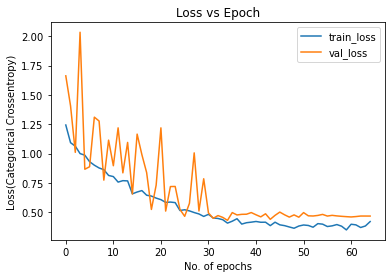

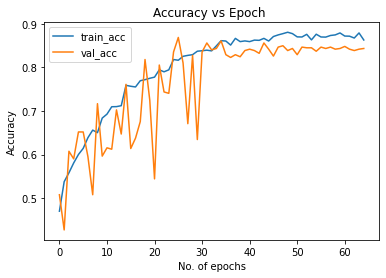

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_3A3['loss'] , label = 'train_loss')
plt.plot(history_3A3['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
plt.savefig('E:/LiverNet/Trial-1/L1_loss.png')
plt.show()
#plt.savefig('90.98_loss.png')
plt.plot(history_3A3['acc'] , label = 'train_acc')
plt.plot(history_3A3['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
plt.savefig('E:/LiverNet/Trial-1/L1_accuracy.png')
plt.show()

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    'E:/TGCA Extended Dataset-2/Test',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 632 images belonging to 4 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model_liver.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

C:\Users\Admin\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


632/632 [==============================] - 20s 30ms/step
[0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 3
 0 3 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 0 0 2 0 0 0 0 2 2 2 3 2 0 2 2 0 0 0 0 0 0 3 0 0 2 2 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 0 3 3 3 3 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 2 0 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 0 2 1 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 3 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 3 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9382911392405063
F1 0.8704318936877076
precision 0.916083916083916
recall 0.8291139240506329
jaccard 0.7705882352941177
_______________________________
class:  1
Accuracy 0.9715189873417721
F1 0.9444444444444444
precision 0.9216867469879518
recall 0.9683544303797469
jaccard 0.8947368421052632
_______________________________
class:  2
Accuracy 0.8971518987341772
F1 0.7962382445141065
precision 0.7888198757763976
recall 0.8037974683544303
jaccard 0.6614583333333334
_______________________________
class:  3
Accuracy 0.930379746835443
F1 0.8624999999999999
precision 0.8518518518518519
recall 0.8734177215189873
jaccard 0.7582417582417582
_______________________________


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.8686708860759493
F1 0.8684036456615646
precision 0.8696105976750295
recall 0.8686708860759493
jaccard 0.7712562922436181
confusion_matrix
 [[131   0  16  11]
 [  0 153   4   1]
 [ 12   7 127  12]
 [  0   6  14 138]]
classification_report
               precision    recall  f1-score   support

           0       0.92      0.83      0.87       158
           1       0.92      0.97      0.94       158
           2       0.79      0.80      0.80       158
           3       0.85      0.87      0.86       158

    accuracy                           0.87       632
   macro avg       0.87      0.87      0.87       632
weighted avg       0.87      0.87      0.87       632




